
<br>
-------------------------------------------------------------------------------<br>
Name:        V4<br>
Purpose:     Model-predictive controller with optimization designated as V4a and V4b in the paper<br>
Author:      Christian Buchholz, Marcus Vogt<br>
Created:     01.12.2021<br>
Copyright:   Chair of Sustainable Manufacturing and Life Cycle Engineering, Institute of Machine Tools and Production Technology, Technische UniversitÃ¤t Braunschweig, Langer Kamp 19b, 38106 Braunschweig, Germany<br>
Licence:     MIT (see License)<br>
-------------------------------------------------------------------------------<br>


In [2]:
import do_mpc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helpers.WetAirToolBox as WetAirToolBox
import helpers.dataPreprocessing as dataPreprocessing
import V4

air properties

In [3]:
activity = 2 # activity level of humans in the room (see helpers.dataPreprocessing.humanheat)

dataPath = os.path.join(os.getcwd(), "data")

# reading weather data
WeatherDataPath = os.path.join(dataPath, "Weatherdata.xlsx")
Weather_LWI = pd.read_excel(WeatherDataPath, engine='openpyxl')
AmbientTemperature = Weather_LWI.Temperatur
AmbientDewPoint = Weather_LWI.Taupunkt
AmbientHumidityAbs = WetAirToolBox.humidity_dewpoint2abs(AmbientTemperature, AmbientDewPoint)
# reading moisture load data
moisture_load = pd.read_csv(os.path.join(dataPath, "moisture_load.csv"))
m_X_delta = moisture_load.moisture_load
# reading predicted number of humans
NumOfHum = pd.read_excel(os.path.join(dataPath, "NumOfHum.xlsx"), engine='openpyxl')
NumOfPersons = NumOfHum.NumOfHum
NumOfPersons_prediction = NumOfPersons.to_numpy()
# reading data which includes: the CO2-concentration of air flow m_in, and examples of
data = pd.read_excel(os.path.join(dataPath, "t_step300_kp-30000_Tf4000_u_massflow.xlsx"), engine='openpyxl')

mpc_type = 'economic' # options: mpc_type = 'economic' -> V4a, mpc_type = 'standard' -> V4b
q = 2000 # weighting factor of the quadratic control difference in the objective function of the MPC
r = 50000 # weighting of the rate of change of the manipulated variable
t_step_controller = 300 # length of a time steps between two calculations of the manipulated variable [sec]
HorizonLength = 1 # length of prediction horizon in hours [h]
T_TP_room_set = -60 # set point of the dew point of the air in the room [°C]
TemperatureIn = 20 # set point of the temperature of the air mass flow m_in [°C]
DewPointIn_set = -60 # set point of the dew point of the air mass flow m_in [°C]
AmbientTemperature_room = 22 # temperature in the building outside the room [°C]
# initial values in the room
T_room_0 = 20  # °C
T_TP_room_0 = -50 # °C
X_room_0 = WetAirToolBox.humidity_dewpoint2abs(T_room_0, T_TP_room_0)  # kg_water/kg_dryair
beta_CO2_room_0 = 350  # ppm CO2

t_step_Measurements_BLB = 60 # length of a time steps between two measurements of the state variables [sec]
t_step_Weather_LWI = 600 # length of a time steps between two weather predictions [sec]

SimulationTime = t_step_Measurements_BLB * (len(moisture_load.index))
hours = 3600 / t_step_controller
n_horizon = HorizonLength * hours
n_horizon = int(n_horizon)
n_steps = int(SimulationTime / t_step_controller) - n_horizon

# define arrays for constant input variables
T_TP_room_set_prediction = T_TP_room_set * np.ones(int(SimulationTime/t_step_controller))
DewPointIn_set_prediction = DewPointIn_set * np.ones(int(SimulationTime / t_step_controller))
TemperatureIn_prediction = TemperatureIn * np.ones(int(SimulationTime / t_step_controller))
AmbientTemperature_room_prediction = AmbientTemperature_room * np.ones(int(SimulationTime / t_step_controller))

# bringing data sets with prediction data to length
m_X_delta_prediction = dataPreprocessing.rescale_data(m_X_delta, int((t_step_Measurements_BLB / t_step_controller) * len(m_X_delta)))
AmbientTemperature_prediction = dataPreprocessing.rescale_data(AmbientTemperature, int((t_step_Weather_LWI / t_step_controller) * len(AmbientTemperature)))
AmbientHumidityAbs_prediction = dataPreprocessing.rescale_data(AmbientHumidityAbs, int((t_step_Weather_LWI / t_step_controller) * len(AmbientHumidityAbs)))



prediction_model = V4.room_model(q, mpc_type)

mpc = V4.mpc_controller(r, prediction_model, t_step_controller, n_horizon, T_TP_room_set_prediction,
                             TemperatureIn_prediction, DewPointIn_set_prediction,
                             AmbientTemperature_room_prediction, AmbientTemperature_prediction, NumOfPersons_prediction,
                             AmbientHumidityAbs_prediction, m_X_delta_prediction, activity)




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Error evaluating objective gradient at user provided starting point.
  No scaling factor for objective function computed!
Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables 

CasADi -  WARNING("S:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 6, col 0).") [.../casadi/core/oracle_function.cpp:265]


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  14 1.5067171e+006 1.95e-005 9.21e-004  -5.7 9.90e-003 -10.2 1.00e+000 1.00e+000h  1
  15 1.5067157e+006 3.63e-008 2.31e-006  -5.7 3.46e-004 -10.7 1.00e+000 1.00e+000h  1
  16 1.5061890e+006 6.62e-004 1.49e-002  -8.6 2.04e-001 -11.2 9.69e-001 9.85e-001h  1
  17 1.5061416e+006 1.22e-004 4.94e-003  -8.6 2.49e-002 -11.6 1.00e+000 1.00e+000h  1
  18 1.5061403e+006 1.93e-005 1.02e-003  -8.6 8.05e-003 -12.1 1.00e+000 1.00e+000h  1
  19 1.5061401e+006 1.90e-006 1.35e-004  -8.6 2.11e-003 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.5061402e+006 6.66e-008 5.26e-006  -8.6 4.79e-004 -13.1 1.00e+000 1.00e+000h  1
  21 1.5061402e+006 2.50e-010 2.03e-008  -8.6 3.22e-005 -13.5 1.00e+000 1.00e+000h  1
In iteration 21, 1 Slack too small, adjusting variable bound
  22 1.5061396e+006 5.00e-008 3.34e-006 -12.9 4.05e-004 -14.0 1.00e+000 9.99e-001h  1
  23 1.5061396e+006 7.53e-011 5.62e-009 -12.9 1.62e-005 -14.5 1.00e+000 1.00e+000h  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4990000e+006 4.55e-003 2.62e-001  -5.7 5.41e-001  -8.3 8.91e-001 1.00e+000f  1
  11 1.4924647e+006 5.99e-002 2.27e-001  -5.7 1.95e+000  -8.8 9.76e-001 1.00e+000h  1
  12 1.4909144e+006 3.44e-003 7.21e-002  -5.7 2.32e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.4909212e+006 2.58e-004 6.69e-003  -5.7 6.63e-002  -9.7 1.00e+000 1.00e+000h  1
  14 1.4909160e+006 1.57e-006 1.44e-004  -5.7 4.38e-003 -10.2 1.00e+000 1.00e+000h  1
  15 1.4909158e+006 6.05e-010 9.34e-008  -5.7 6.14e-005 -10.7 1.00e+000 1.00e+000h  1
  16 1.4905096e+006 5.84e-004 1.07e-002  -8.6 8.82e-002 -11.2 9.64e-001 9.77e-001h  1
  17 1.4905013e+006 1.76e-004 2.13e-003  -8.6 5.44e-002 -11.6 1.00e+000 1.00e+000h  1
  18 1.4905053e+006 5.06e-006 1.13e-004  -8.6 8.28e-003 -12.1 1.00e+000 1.00e+000h  1
  19 1.4905056e+006 4.82e-009 5.00e-007  -8.6 2.17e-004 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  12 1.4968223e+006 1.79e-003 5.89e-002  -5.7 1.78e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.4968554e+006 4.51e-005 4.50e-003  -5.7 2.34e-002  -9.7 1.00e+000 1.00e+000h  1
  14 1.4968484e+006 4.77e-007 7.49e-005  -5.7 1.80e-003 -10.2 1.00e+000 1.00e+000h  1
  15 1.4968483e+006 1.42e-010 2.59e-008  -5.7 3.59e-005 -10.7 1.00e+000 1.00e+000h  1
  16 1.4964973e+006 1.95e-004 8.15e-003  -8.6 5.81e-002 -11.2 9.74e-001 9.84e-001h  1
  17 1.4964940e+006 1.52e-005 9.36e-004  -8.6 1.73e-002 -11.6 1.00e+000 1.00e+000h  1
  18 1.4964959e+006 1.67e-007 2.28e-005  -8.6 1.11e-003 -12.1 1.00e+000 1.00e+000h  1
  19 1.4964959e+006 2.25e-010 3.77e-008  -8.6 4.59e-005 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.4964959e+006 1.42e-014 1.42e-013  -8.6 8.13e-008 -13.1 1.00e+000 1.00e+000h  1
  21 1.4964955e+006 9.62e-010 7.77e-008 -12.9 1.31e-004 -13.5 1.00e+000 1.00e+000h  1
  22 1.4964955e+006 2.84e-014 2.84e-013 -12.9 1.00e-007 -14

   8 1.5074363e+006 4.96e-006 5.06e-004  -3.8 6.73e-003  -7.3 1.00e+000 1.00e+000h  1
   9 1.4965130e+006 2.78e-003 2.95e-001  -5.7 2.51e-001  -7.8 9.03e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4893643e+006 1.57e-002 2.37e-001  -5.7 9.93e-001  -8.3 9.93e-001 1.00e+000h  1
  11 1.4880960e+006 1.48e-003 6.14e-002  -5.7 2.94e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.4880372e+006 4.05e-005 4.71e-003  -5.7 1.33e-002  -9.2 1.00e+000 1.00e+000h  1
  13 1.4880298e+006 5.23e-007 6.98e-005  -5.7 1.64e-003  -9.7 1.00e+000 1.00e+000h  1
  14 1.4880297e+006 1.64e-010 2.27e-008  -5.7 3.08e-005 -10.2 1.00e+000 1.00e+000h  1
  15 1.4875700e+006 1.52e-004 8.94e-003  -8.6 9.82e-002 -10.7 9.82e-001 1.00e+000h  1
  16 1.4875566e+006 9.59e-006 1.06e-003  -8.6 7.25e-003 -11.2 1.00e+000 1.00e+000h  1
  17 1.4875570e+006 2.54e-007 2.72e-005  -8.6 1.15e-003 -11.6 1.00e+000 1.00e+000h  1
  18 1.4875571e+006 4.02e-010 4.17e-008  -8.6 4.72e-005 -12

   2 1.5176893e+006 6.36e-002 3.47e+000  -1.0 1.97e+000  -4.5 9.99e-001 1.00e+000f  1
   3 1.5374269e+006 1.87e-003 1.61e-001  -1.0 2.24e-001  -5.0 1.00e+000 1.00e+000h  1
   4 1.5374175e+006 2.02e-006 1.24e-003  -2.5 3.76e-003  -5.4 1.00e+000 1.00e+000h  1
   5 1.5288262e+006 9.09e-004 7.64e-002  -3.8 1.11e-001  -5.9 9.58e-001 1.00e+000h  1
   6 1.4988329e+006 1.24e-002 1.03e+000  -3.8 3.83e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.4933896e+006 7.25e-004 8.45e-002  -3.8 1.51e-001  -6.9 1.00e+000 1.00e+000h  1
   8 1.4932220e+006 4.59e-006 4.65e-004  -3.8 6.49e-003  -7.3 1.00e+000 1.00e+000h  1
   9 1.4809519e+006 2.81e-003 3.00e-001  -5.7 3.88e-001  -7.8 8.98e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4718912e+006 4.61e-002 2.46e-001  -5.7 1.69e+000  -8.3 8.69e-001 1.00e+000h  1
  11 1.4701286e+006 4.72e-003 5.85e-002  -5.7 4.65e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.4698962e+006 9.53e-005 6.70e-003  -5.7 1.45e-002  -9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.4233815e+006 3.39e-001 2.68e-004  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   2 1.4425036e+006 3.37e-002 3.13e+000  -1.0 5.74e-001  -4.5 9.97e-001 1.00e+000f  1
   3 1.4674371e+006 3.48e-003 2.52e-001  -1.0 2.18e-001  -5.0 1.00e+000 1.00e+000h  1
   4 1.4677368e+006 2.38e-006 1.01e-003  -1.7 1.20e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.4661701e+006 2.56e-005 2.85e-003  -3.8 1.88e-002  -5.9 9.90e-001 1.00e+000h  1
   6 1.4291748e+006 1.52e-002 1.19e+000  -3.8 4.37e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.4168440e+006 1.82e-003 2.16e-001  -3.8 1.21e-001  -6.9 1.00e+000 1.00e+000h  1
   8 1.4166401e+006 1.76e-005 1.82e-003  -3.8 1.25e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.4166345e+006 2.38e-009 2.53e-007  -3.8 1.52e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4017787e+006 2.85e-003 3.02e-001  -5.7 1.97e-001  -8.3 8.83e-001 1.00e+000f  1
  11 1.3910001e+006 8.89e-003 2.18e-001  -5.7 7.37e-001  -8.8 9.50e-001 1.00e+000h  1
  12 1.3882619e+006 2.38e-003 6.77e-002  -5.7 2.13e-001  -9

   1 1.3826877e+006 7.69e-003 7.36e-001  -1.0 4.13e-001  -4.0 9.83e-001 1.00e+000f  1
   2 1.4246722e+006 6.10e-002 3.04e+000  -1.0 1.91e+000  -4.5 9.96e-001 1.00e+000f  1
   3 1.4510999e+006 3.45e-003 2.89e-001  -1.0 2.35e-001  -5.0 1.00e+000 1.00e+000h  1
   4 1.4514870e+006 2.52e-006 1.04e-003  -1.7 1.12e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.4499873e+006 2.44e-005 2.71e-003  -3.8 1.83e-002  -5.9 9.90e-001 1.00e+000h  1
   6 1.4141182e+006 1.47e-002 1.18e+000  -3.8 4.29e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.4019543e+006 1.72e-003 2.02e-001  -3.8 1.74e-001  -6.9 1.00e+000 1.00e+000h  1
   8 1.4018084e+006 1.77e-005 1.82e-003  -3.8 1.26e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.4018029e+006 2.62e-009 2.78e-007  -3.8 1.60e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3866432e+006 2.86e-003 3.02e-001  -5.7 3.53e-001  -8.3 8.79e-001 1.00e+000f  1
  11 1.3743722e+006 2.94e-002 2.25e-001  -5.7 1.34e+000  -8

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3660517e+006 2.72e-001 2.77e-004  -1.0 0.00e+000    -  0.00e+00

  11 1.3462475e+006 1.18e-002 2.29e-001  -5.7 6.14e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.3415631e+006 1.60e-002 9.17e-002  -5.7 8.56e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.3413085e+006 5.14e-004 4.27e-003  -5.7 1.60e-001  -9.7 1.00e+000 1.00e+000h  1
  14 1.3412893e+006 3.21e-006 2.43e-005  -5.7 1.24e-002 -10.2 1.00e+000 1.00e+000h  1
  15 1.3412891e+006 2.31e-010 1.53e-009  -5.7 1.04e-004 -10.7 1.00e+000 1.00e+000h  1
  16 1.3400127e+006 2.24e-003 8.82e-003  -8.6 3.35e-001 -11.2 9.64e-001 1.00e+000h  1
  17 1.3398716e+006 7.21e-004 1.47e-003  -8.6 1.89e-001 -11.6 1.00e+000 9.84e-001h  1
  18 1.3398644e+006 1.59e-004 2.51e-004  -8.6 8.80e-002 -12.1 1.00e+000 1.00e+000h  1
  19 1.3398639e+006 3.29e-005 5.19e-005  -8.6 3.98e-002 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3398638e+006 4.76e-006 7.51e-006  -8.6 1.52e-002 -13.1 1.00e+000 1.00e+000h  1
  21 1.3398638e+006 1.98e-007 3.12e-007  -8.6 3.09e-003 -13

   6 1.3900470e+006 1.55e-002 1.17e+000  -3.8 4.43e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.3779811e+006 1.83e-003 2.14e-001  -3.8 1.41e-001  -6.9 1.00e+000 1.00e+000h  1
   8 1.3777351e+006 1.79e-005 1.84e-003  -3.8 1.26e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.3777295e+006 2.20e-009 2.32e-007  -3.8 1.46e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3632426e+006 2.83e-003 2.97e-001  -5.7 1.94e-001  -8.3 8.77e-001 1.00e+000f  1
  11 1.3522238e+006 1.01e-002 2.14e-001  -5.7 6.25e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.3482748e+006 1.76e-002 9.02e-002  -5.7 9.41e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.3480750e+006 6.54e-004 5.21e-003  -5.7 1.92e-001  -9.7 1.00e+000 1.00e+000h  1
  14 1.3480566e+006 3.13e-006 4.53e-005  -5.7 1.28e-002 -10.2 1.00e+000 1.00e+000h  1
  15 1.3480565e+006 1.59e-010 5.22e-009  -5.7 6.92e-005 -10.7 1.00e+000 1.00e+000h  1
  16 1.3468974e+006 2.83e-003 1.16e-002  -8.6 3.93e-001 -11

   3 1.4310650e+006 3.70e-002 3.68e-001  -1.0 1.57e+000  -5.0 1.00e+000 1.00e+000h  1
   4 1.4319165e+006 1.66e-005 2.34e-003  -1.7 2.42e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.4303074e+006 2.58e-005 2.60e-003  -3.8 1.88e-002  -5.9 9.90e-001 1.00e+000h  1
   6 1.3917794e+006 1.56e-002 1.18e+000  -3.8 4.43e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.3787403e+006 1.82e-003 2.14e-001  -3.8 1.20e-001  -6.9 1.00e+000 1.00e+000h  1
   8 1.3785480e+006 1.66e-005 1.70e-003  -3.8 1.21e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.3785425e+006 2.03e-009 2.14e-007  -3.8 1.41e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3628339e+006 2.86e-003 2.98e-001  -5.7 1.63e-001  -8.3 8.76e-001 1.00e+000f  1
  11 1.3512714e+006 5.18e-003 2.08e-001  -5.7 3.47e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.3476894e+006 1.05e-002 8.01e-002  -5.7 6.19e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.3475744e+006 5.14e-004 4.38e-003  -5.7 1.18e-001  -9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3071947e+006 5.27e-001 3.58e-004  -1.0 0.00e+000    -  0.00e+00

  11 1.2517500e+006 1.22e-002 6.92e-002  -5.7 6.70e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.2516685e+006 5.42e-004 2.83e-003  -5.7 1.34e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.2516629e+006 3.25e-006 1.51e-005  -5.7 9.60e-003  -9.7 1.00e+000 1.00e+000h  1
  14 1.2504476e+006 2.10e-003 9.22e-003  -8.6 2.75e-001 -10.2 9.73e-001 1.00e+000h  1
  15 1.2503653e+006 7.80e-004 2.80e-003  -8.6 1.66e-001 -10.7 1.00e+000 1.00e+000h  1
  16 1.2503610e+006 9.88e-005 3.25e-004  -8.6 5.60e-002 -11.2 1.00e+000 1.00e+000h  1
  17 1.2503609e+006 4.16e-006 1.18e-005  -8.6 1.12e-002 -11.6 1.00e+000 1.00e+000h  1
  18 1.2503609e+006 1.39e-008 3.48e-008  -8.6 6.49e-004 -12.1 1.00e+000 1.00e+000h  1
  19 1.2503609e+006 2.17e-013 5.68e-013  -8.6 2.58e-006 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.2503590e+006 1.52e-007 5.06e-007 -12.9 2.24e-003 -13.1 1.00e+000 1.00e+000h  1
  21 1.2503590e+006 1.42e-011 3.80e-011 -12.9 2.10e-005 -13

   9 1.2126566e+006 2.75e-003 2.29e-001  -5.7 1.59e-001  -7.8 8.63e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1961870e+006 7.95e-003 1.34e-001  -5.7 3.41e-001  -8.3 1.00e+000 1.00e+000h  1
  11 1.1916734e+006 1.07e-002 5.61e-002  -5.7 5.88e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.1916276e+006 4.50e-004 1.77e-003  -5.7 1.20e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.1916245e+006 3.06e-006 9.80e-006  -5.7 9.54e-003  -9.7 1.00e+000 1.00e+000h  1
  14 1.1903124e+006 1.64e-003 6.37e-003  -8.6 2.32e-001 -10.2 9.80e-001 1.00e+000h  1
  15 1.1902559e+006 5.08e-004 1.40e-003  -8.6 1.31e-001 -10.7 1.00e+000 9.97e-001h  1
  16 1.1902560e+006 6.79e-005 1.68e-004  -8.6 4.59e-002 -11.2 1.00e+000 1.00e+000h  1
  17 1.1902561e+006 4.98e-006 1.27e-005  -8.6 1.22e-002 -11.6 1.00e+000 1.00e+000h  1
  18 1.1902561e+006 4.13e-008 1.06e-007  -8.6 1.11e-003 -12.1 1.00e+000 1.00e+000h  1
  19 1.1902561e+006 2.98e-012 7.65e-012  -8.6 9.42e-006 -12

  11 1.1365481e+006 1.48e-002 4.81e-002  -5.7 8.29e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.1365420e+006 5.11e-004 1.16e-003  -5.7 1.58e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.1365402e+006 3.64e-006 6.20e-006  -5.7 1.31e-002  -9.7 1.00e+000 1.00e+000h  1
  14 1.1350817e+006 1.93e-003 4.76e-003  -8.6 3.08e-001 -10.2 9.82e-001 1.00e+000h  1
  15 1.1350294e+006 5.81e-004 1.00e-003  -8.6 1.69e-001 -10.7 1.00e+000 9.87e-001h  1
  16 1.1350289e+006 8.08e-005 1.25e-004  -8.6 6.25e-002 -11.2 1.00e+000 1.00e+000h  1
  17 1.1350289e+006 3.57e-006 5.59e-006  -8.6 1.31e-002 -11.6 1.00e+000 1.00e+000h  1
  18 1.1350289e+006 9.16e-009 1.43e-008  -8.6 6.63e-004 -12.1 1.00e+000 1.00e+000h  1
In iteration 18, 1 Slack too small, adjusting variable bound
  19 1.1350269e+006 1.21e-007 2.10e-007 -12.9 2.43e-003 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.1350269e+006 1.17e-011 1.82e-011 -12.9 2.37e-005 -13.1 1.00e+000 1.00e+000h  

   9 1.1552280e+006 1.75e-009 1.81e-007  -3.8 1.30e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1312728e+006 3.87e-003 2.87e-001  -5.7 3.64e-001  -8.3 8.51e-001 1.00e+000f  1
  11 1.1115061e+006 1.79e-002 1.45e-001  -5.7 9.46e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.1051248e+006 2.10e-002 4.53e-002  -5.7 1.15e+000  -9.2 1.00e+000 1.00e+000h  1
  13 1.1051278e+006 6.74e-004 1.08e-003  -5.7 2.11e-001  -9.7 1.00e+000 1.00e+000h  1
  14 1.1051254e+006 6.34e-006 7.30e-006  -5.7 2.03e-002 -10.2 1.00e+000 1.00e+000h  1
  15 1.1035324e+006 2.05e-003 3.89e-003  -8.6 3.61e-001 -10.7 9.82e-001 1.00e+000h  1
  16 1.1034698e+006 6.61e-004 8.53e-004  -8.6 2.05e-001 -11.2 1.00e+000 9.88e-001h  1
  17 1.1034682e+006 1.32e-004 1.46e-004  -8.6 9.23e-002 -11.6 1.00e+000 1.00e+000h  1
  18 1.1034681e+006 1.45e-005 1.60e-005  -8.6 3.06e-002 -12.1 1.00e+000 1.00e+000h  1
  19 1.1034681e+006 3.05e-007 3.38e-007  -8.6 4.44e-003 -12

   3 1.2304942e+006 8.22e-002 3.39e-001  -1.0 2.40e+000  -5.0 1.00e+000 1.00e+000f  1
   4 1.2313625e+006 2.35e-005 3.31e-003  -1.7 3.47e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.2295523e+006 2.69e-005 2.58e-003  -3.8 1.92e-002  -5.9 9.90e-001 1.00e+000h  1
   6 1.1849121e+006 1.59e-002 1.19e+000  -3.8 4.46e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.1649330e+006 3.50e-003 2.35e-001  -3.8 3.51e-001  -6.9 1.00e+000 1.00e+000h  1
   8 1.1650807e+006 1.60e-005 1.68e-003  -3.8 1.19e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.1650742e+006 2.07e-009 2.18e-007  -3.8 1.42e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1424724e+006 4.81e-003 2.97e-001  -5.7 4.11e-001  -8.3 8.51e-001 1.00e+000f  1
  11 1.1227954e+006 1.97e-002 1.71e-001  -5.7 1.02e+000  -8.8 1.00e+000 1.00e+000h  1
  12 1.1159759e+006 1.89e-002 3.74e-002  -5.7 1.11e+000  -9.2 1.00e+000 1.00e+000h  1
  13 1.1159780e+006 7.15e-004 1.03e-003  -5.7 2.17e-001  -9

   9 1.1629555e+006 2.08e-009 2.19e-007  -3.8 1.42e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1414182e+006 5.60e-003 2.98e-001  -5.7 5.45e-001  -8.3 8.53e-001 1.00e+000f  1
  11 1.1223029e+006 2.30e-002 1.83e-001  -5.7 1.18e+000  -8.8 1.00e+000 1.00e+000h  1
  12 1.1150956e+006 1.32e-002 3.71e-002  -5.7 9.68e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.1150752e+006 2.58e-004 3.20e-004  -5.7 1.32e-001  -9.7 1.00e+000 1.00e+000h  1
  14 1.1150724e+006 5.25e-007 5.67e-007  -5.7 5.87e-003 -10.2 1.00e+000 1.00e+000h  1
  15 1.1134122e+006 9.33e-004 1.71e-003  -8.6 2.45e-001 -10.7 9.83e-001 1.00e+000h  1
  16 1.1133421e+006 3.33e-005 4.28e-005  -8.6 4.66e-002 -11.2 1.00e+000 1.00e+000h  1
  17 1.1133417e+006 2.13e-008 2.27e-008  -8.6 1.18e-003 -11.6 1.00e+000 1.00e+000h  1
  18 1.1133392e+006 3.67e-009 6.05e-009 -12.9 4.87e-004 -12.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                            

  19 1.1466829e+006 6.51e-009 1.14e-008 -12.9 6.47e-004 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.1466829e+006 1.42e-014 2.84e-013 -12.9 3.58e-007 -13.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:  1.4154613702437105e-002   1.1466829417505513e+006
Dual infeasibility......:  2.8421709430404007e-013   2.3024781929317981e-005
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  1.2544334708858542e-013   1.0162322284910392e-005
Overall NLP error.......:  2.8421709430404007e-013   2.3024781929317981e-005


Number of objective function evaluations             = 21
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 21
Number of inequality constraint evaluations          = 0
Number of equality constrai

  15 1.1540087e+006 1.79e-003 3.92e-003  -8.6 3.47e-001 -10.7 9.79e-001 1.00e+000h  1
  16 1.1539131e+006 2.82e-004 4.16e-004  -8.6 1.35e-001 -11.2 1.00e+000 1.00e+000h  1
  17 1.1539098e+006 6.52e-006 7.45e-006  -8.6 2.05e-002 -11.6 1.00e+000 1.00e+000h  1
  18 1.1539097e+006 4.31e-009 4.96e-009  -8.6 5.28e-004 -12.1 1.00e+000 1.00e+000h  1
  19 1.1539073e+006 2.07e-008 3.46e-008 -12.9 1.15e-003 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.1539073e+006 2.84e-014 2.84e-013 -12.9 1.80e-006 -13.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:  1.4379731095224661e-002   1.1539073008768773e+006
Dual infeasibility......:  2.8421709430404007e-013   2.2807114957828071e-005
Constraint violation....:  2.8421709430404007e-014   2.8421709430404007e-014
Complementarity.........:  1.2545163727763384e-013   1.006691705171680

       nlp_g  |        0 (       0)        0 (       0)        21
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |  16.00ms (727.27us)  15.96ms (725.36us)        22
  nlp_hess_l  |        0 (       0)        0 (       0)        20
   nlp_jac_g  |        0 (       0)        0 (       0)        22
       total  |  72.00ms ( 72.00ms)  72.45ms ( 72.45ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number

  10 1.1472668e+006 4.42e-003 3.14e-001  -5.7 4.64e-001  -8.3 8.53e-001 1.00e+000f  1
  11 1.1294891e+006 2.02e-002 1.79e-001  -5.7 1.09e+000  -8.8 1.00e+000 1.00e+000h  1
  12 1.1230786e+006 1.80e-002 4.20e-002  -5.7 1.08e+000  -9.2 1.00e+000 1.00e+000h  1
  13 1.1230372e+006 4.49e-004 7.39e-004  -5.7 1.73e-001  -9.7 1.00e+000 1.00e+000h  1
  14 1.1230338e+006 1.95e-006 2.36e-006  -5.7 1.13e-002 -10.2 1.00e+000 1.00e+000h  1
  15 1.1215000e+006 1.33e-003 2.83e-003  -8.6 2.91e-001 -10.7 9.82e-001 1.00e+000h  1
  16 1.1214274e+006 1.09e-004 1.59e-004  -8.6 8.37e-002 -11.2 1.00e+000 1.00e+000h  1
  17 1.1214260e+006 4.74e-007 5.58e-007  -8.6 5.54e-003 -11.6 1.00e+000 1.00e+000h  1
  18 1.1214260e+006 9.76e-012 1.16e-011  -8.6 2.52e-005 -12.1 1.00e+000 1.00e+000h  1
  19 1.1214237e+006 8.10e-009 1.45e-008 -12.9 7.20e-004 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.1214237e+006 1.42e-014 3.84e-013 -12.9 4.97e-007 -13

  18 1.1200988e+006 3.17e-009 6.23e-009 -12.9 4.50e-004 -12.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:  1.4767626746274062e-002   1.1200987803738560e+006
Dual infeasibility......:  6.2266849454317708e-009   4.7228321334097056e-001
Constraint violation....:  3.1654110443923855e-009   3.1654110443923855e-009
Complementarity.........:  8.9128180467365553e-013   6.7602173290048266e-005
Overall NLP error.......:  6.2266849454317708e-009   4.7228321334097056e-001


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 19
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 19
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in IPO

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.1343589e+006 9.59e-001 4.19e-004  -1.0 0.00e+000    -  0.00e+00

   8 1.1718912e+006 1.99e-005 2.32e-003  -3.8 1.31e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.1718825e+006 3.80e-009 4.40e-007  -3.8 1.93e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1504908e+006 3.39e-003 3.14e-001  -5.7 4.41e-001  -8.3 8.54e-001 1.00e+000f  1
  11 1.1333783e+006 1.88e-002 1.57e-001  -5.7 1.06e+000  -8.8 1.00e+000 1.00e+000h  1
  12 1.1275172e+006 1.98e-002 5.21e-002  -5.7 1.11e+000  -9.2 1.00e+000 1.00e+000h  1
  13 1.1274529e+006 4.33e-004 8.89e-004  -5.7 1.69e-001  -9.7 1.00e+000 1.00e+000h  1
  14 1.1274496e+006 1.59e-006 2.10e-006  -5.7 1.02e-002 -10.2 1.00e+000 1.00e+000h  1
  15 1.1259666e+006 1.33e-003 3.20e-003  -8.6 3.08e-001 -10.7 9.82e-001 1.00e+000h  1
  16 1.1258889e+006 9.54e-005 1.68e-004  -8.6 7.84e-002 -11.2 1.00e+000 1.00e+000h  1
  17 1.1258877e+006 3.11e-007 3.89e-007  -8.6 4.48e-003 -11.6 1.00e+000 1.00e+000h  1
  18 1.1258877e+006 4.02e-012 5.06e-012  -8.6 1.61e-005 -12

  14 1.1505439e+006 2.28e-006 3.00e-006  -5.7 1.21e-002 -10.2 1.00e+000 1.00e+000h  1
  15 1.1490605e+006 1.41e-003 3.17e-003  -8.6 3.10e-001 -10.7 9.81e-001 1.00e+000h  1
  16 1.1489853e+006 1.31e-004 2.08e-004  -8.6 9.16e-002 -11.2 1.00e+000 1.00e+000h  1
  17 1.1489837e+006 7.72e-007 9.51e-007  -8.6 7.05e-003 -11.6 1.00e+000 1.00e+000h  1
  18 1.1489837e+006 3.19e-011 3.94e-011  -8.6 4.53e-005 -12.1 1.00e+000 1.00e+000h  1
  19 1.1489815e+006 9.41e-009 1.78e-008 -12.9 7.75e-004 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.1489815e+006 1.42e-014 2.70e-013 -12.9 6.09e-007 -13.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:  1.5458679856940808e-002   1.1489814955060959e+006
Dual infeasibility......:  2.7000623958883807e-013   2.0068477763285133e-005
Constraint violation....:  1.4210854715202004e-014   1.421085

  11 1.1882320e+006 2.25e-002 2.26e-001  -5.7 1.16e+000  -8.8 1.00e+000 1.00e+000h  1
  12 1.1816601e+006 1.37e-002 6.44e-002  -5.7 9.61e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.1815385e+006 2.35e-004 1.02e-003  -5.7 1.25e-001  -9.7 1.00e+000 1.00e+000h  1
  14 1.1815317e+006 4.22e-007 9.11e-007  -5.7 5.24e-003 -10.2 1.00e+000 1.00e+000h  1
  15 1.1800340e+006 8.65e-004 3.62e-003  -8.6 2.34e-001 -10.7 9.79e-001 1.00e+000h  1
  16 1.1799558e+006 2.82e-005 4.35e-005  -8.6 4.26e-002 -11.2 1.00e+000 1.00e+000h  1
  17 1.1799552e+006 1.63e-008 1.95e-008  -8.6 1.03e-003 -11.6 1.00e+000 1.00e+000h  1
  18 1.1799529e+006 3.29e-009 9.49e-009 -12.9 4.58e-004 -12.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:  1.5750663799382052e-002   1.1799529451765176e+006
Dual infeasibility......:  9.4932772753963945e-009   7.1118402520411594e-001
Constraint violation....:  3.2926976700764499e-009   3.2

  12 1.2391179e+006 1.37e-002 9.28e-002  -5.7 9.56e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.2389093e+006 1.90e-004 3.56e-003  -5.7 1.13e-001  -9.7 1.00e+000 1.00e+000h  1
  14 1.2388939e+006 2.46e-007 1.95e-005  -5.7 4.01e-003 -10.2 1.00e+000 1.00e+000h  1
  15 1.2388938e+006 9.07e-012 1.11e-009  -5.7 6.78e-006 -10.7 1.00e+000 1.00e+000h  1
  16 1.2374595e+006 8.06e-004 7.43e-003  -8.6 2.30e-001 -11.2 9.73e-001 1.00e+000f  1
  17 1.2373491e+006 2.18e-005 2.51e-004  -8.6 3.74e-002 -11.6 1.00e+000 1.00e+000h  1
  18 1.2373472e+006 9.04e-009 5.65e-007  -8.6 7.65e-004 -12.1 1.00e+000 1.00e+000h  1
  19 1.2373472e+006 7.61e-014 1.05e-011  -8.6 7.44e-007 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.2373449e+006 2.86e-009 2.90e-008 -12.9 4.27e-004 -13.1 1.00e+000 1.00e+000h  1
  21 1.2373449e+006 1.42e-014 2.84e-013 -12.9 1.22e-007 -13.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                            

  14 1.2978582e+006 1.21e-006 4.94e-005  -5.7 7.27e-003 -10.2 1.00e+000 1.00e+000h  1
  15 1.2978580e+006 1.26e-010 6.76e-009  -5.7 2.31e-005 -10.7 1.00e+000 1.00e+000h  1
  16 1.2965465e+006 1.09e-003 1.15e-002  -8.6 2.71e-001 -11.2 9.66e-001 1.00e+000h  1
  17 1.2963968e+006 5.61e-005 1.42e-003  -8.6 6.01e-002 -11.6 1.00e+000 1.00e+000h  1
  18 1.2963889e+006 7.22e-007 3.27e-005  -8.6 2.62e-003 -12.1 1.00e+000 1.00e+000h  1
  19 1.2963887e+006 8.78e-010 4.90e-008  -8.6 4.52e-005 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.2963887e+006 1.42e-014 2.84e-013  -8.6 1.24e-007 -13.1 1.00e+000 1.00e+000h  1
  21 1.2963864e+006 5.09e-009 1.17e-007 -12.9 5.70e-004 -13.5 1.00e+000 1.00e+000h  1
  22 1.2963864e+006 1.07e-014 3.41e-013 -12.9 2.65e-007 -14.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:  1.71246466056012

   3 1.4219260e+006 7.50e-002 4.14e-001  -1.0 2.27e+000  -5.0 1.00e+000 1.00e+000f  1
   4 1.4230894e+006 2.12e-005 3.19e-003  -1.7 3.02e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.4215386e+006 2.82e-005 2.75e-003  -3.8 1.98e-002  -5.9 9.89e-001 1.00e+000h  1
   6 1.3883658e+006 1.44e-002 1.28e+000  -3.8 4.26e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.3770127e+006 1.95e-003 2.46e-001  -3.8 2.80e-001  -6.9 1.00e+000 1.00e+000h  1
   8 1.3768039e+006 2.49e-005 2.77e-003  -3.8 1.49e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.3767965e+006 5.57e-009 6.41e-007  -3.8 2.34e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3640167e+006 2.71e-003 3.15e-001  -5.7 3.38e-001  -8.3 8.77e-001 1.00e+000f  1
  11 1.3539223e+006 1.46e-002 2.35e-001  -5.7 9.54e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.3500096e+006 2.07e-002 9.28e-002  -5.7 1.12e+000  -9.2 1.00e+000 1.00e+000h  1
  13 1.3497766e+006 8.15e-004 5.48e-003  -5.7 2.42e-001  -9

   3 1.4499853e+006 7.82e-002 4.23e-001  -1.0 2.33e+000  -5.0 1.00e+000 1.00e+000f  1
   4 1.4512357e+006 2.25e-005 3.24e-003  -1.7 3.22e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.4498043e+006 2.62e-005 2.57e-003  -3.8 1.90e-002  -5.9 9.90e-001 1.00e+000h  1
   6 1.4187360e+006 1.37e-002 1.24e+000  -3.8 4.15e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.4087846e+006 1.78e-003 2.21e-001  -3.8 2.13e-001  -6.9 1.00e+000 1.00e+000h  1
   8 1.4086097e+006 2.40e-005 2.61e-003  -3.8 1.48e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.4086031e+006 5.68e-009 6.46e-007  -3.8 2.37e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3967799e+006 2.69e-003 3.10e-001  -5.7 2.60e-001  -8.3 8.79e-001 1.00e+000f  1
  11 1.3872957e+006 8.76e-003 2.46e-001  -5.7 7.48e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.3836746e+006 1.67e-002 9.28e-002  -5.7 9.99e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.3834783e+006 9.10e-004 4.74e-003  -5.7 2.47e-001  -9

   0 1.4107848e+006 2.63e-001 2.04e-004  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.4313404e+006 2.05e-002 2.53e-001  -1.0 8.91e-001  -4.0 9.89e-001 1.00e+000f  1
   2 1.4584317e+006 3.35e-002 3.28e+000  -1.0 5.72e-001  -4.5 9.99e-001 1.00e+000f  1
   3 1.4818065e+006 6.50e-002 4.04e-001  -1.0 2.10e+000  -5.0 1.00e+000 1.00e+000f  1
   4 1.4831330e+006 1.71e-005 3.03e-003  -1.7 2.44e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.4819061e+006 2.20e-005 2.27e-003  -3.8 1.76e-002  -5.9 9.91e-001 1.00e+000h  1
   6 1.4550908e+006 1.25e-002 1.10e+000  -3.8 3.99e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.4478299e+006 1.41e-003 1.51e-001  -3.8 1.66e-001  -6.9 1.00e+000 1.00e+000h  1
   8 1.4476762e+006 2.03e-005 2.06e-003  -3.8 1.38e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.4476712e+006 4.35e-009 4.65e-007  -3.8 2.08e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4379080e+006 2.59e-003 2.65e-001  -5.7 2.07e-001  -8

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.4386196e+006 3.62e-001 2.41e-004  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.4403427e+006 2.04e-002 7.82e-001  -1.0 8.61e-001  -4.0 9.89e-001 1.00e+000f  1
   2 1.4703072e+006 3.34e-002 3.43e+000  -1.0 5.73e-001  -4.5 9.99e-001 1.00e+000f  1
   3 1.4923570e+006 6.36e-002 3.79e-001  -1.0 2.07e+000  -5.0 1.00e+000 1.00e+000f  

   2 1.5099597e+006 3.51e-002 3.49e+000  -1.0 5.82e-001  -4.5 9.99e-001 1.00e+000f  1
   3 1.5304846e+006 7.04e-002 2.89e-001  -1.0 2.20e+000  -5.0 1.00e+000 1.00e+000f  1
   4 1.5313998e+006 1.63e-005 2.22e-003  -1.7 3.17e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.5301681e+006 2.25e-005 2.42e-003  -3.8 1.77e-002  -5.9 9.91e-001 1.00e+000h  1
   6 1.5029566e+006 1.29e-002 1.13e+000  -3.8 4.04e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.4963642e+006 1.44e-003 1.63e-001  -3.8 1.70e-001  -6.9 1.00e+000 1.00e+000h  1
   8 1.4961262e+006 2.01e-005 2.05e-003  -3.8 1.37e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.4961214e+006 3.95e-009 4.26e-007  -3.8 1.97e-004  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4870853e+006 2.64e-003 2.81e-001  -5.7 2.37e-001  -8.3 8.96e-001 1.00e+000f  1
  11 1.4803690e+006 1.05e-002 2.43e-001  -5.7 8.03e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.4782548e+006 1.55e-002 6.79e-002  -5.7 9.60e-001  -9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   1 1.8583036e+006 2.60e-003 1.80e+000  -1.0 3.35e-001  -4.0 9.90e-001 1.00e+000h  1
   2 1.8528005e+006 1.60e-002 1.16e+000  -1.0 7.21e-001  -4.5 9.99e-001 1.00e+000f  1
   3 1.8580196e+006 4.24e-003 1.07e-002  -1.0 5.09e-001  -5.0 1.00e+000 1.00e+000h  1
   4 1.8579997e+006 2.61e-007 6.16e-004  -2.5 1.82e-003  -5.4 1.00e+000 1.00e+000h  1
   5 1.8559223e+006 1.58e-004 1.37e-002  -3.8 5.07e-002  -5.9 1.00e+000 1.00e+000h  1
   6 1.8516727e+006 1.54e-003 1.29e-001  -3.8 1.53e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.8519377e+006 1.45e-005 1.19e-003  -3.8 1.13e-002  -6.9 1.00e+000 1.00e+000h  1
   8 1.8513931e+006 1.60e-004 1.29e-002  -5.7 5.28e-002  -7.3 9.59e-001 1.00e+000h  1
   9 1.8510254e+006 4.35e-003 2.35e-002  -5.7 3.37e-001  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.8510227e+006 2.19e-004 5.51e-003  -5.7 4.77e-002  -8.3 1.00e+000 1.00e+000h  1
  11 1.8510289e+006 3.08e-006 6.05e-005  -5.7 3.87e-003  -8

  17 2.1687396e+006 4.72e-010 1.34e-009 -12.9 1.67e-004 -11.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:  2.4403330718140579e-002   2.1687395909788953e+006
Dual infeasibility......:  1.3430394574243110e-009   1.1935677458150072e-001
Constraint violation....:  4.7172932227113051e-010   4.7172932227113051e-010
Complementarity.........:  1.6015783471943155e-013   1.4233329088282389e-005
Overall NLP error.......:  1.3430394574243110e-009   1.1935677458150072e-001


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 19
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 17
Total CPU secs in IPO

  16 2.9154933e+006 5.45e-008 6.73e-008  -5.7 1.85e-003 -11.2 1.00e+000 1.00e+000h  1
  17 2.9154142e+006 1.94e-003 4.64e-003  -8.6 3.00e-001 -11.6 9.63e-001 1.00e+000h  1
  18 2.9154454e+006 8.90e-007 1.16e-006  -8.6 6.55e-003 -12.1 1.00e+000 1.00e+000h  1
  19 2.9154454e+006 2.84e-014 1.71e-013  -8.6 3.79e-007 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.9154454e+006 3.91e-009 9.01e-009 -12.9 4.25e-004 -13.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:  3.2787910050408889e-002   2.9154454447880494e+006
Dual infeasibility......:  9.0130924945697188e-009   8.0142892353759365e-001
Constraint violation....:  3.9077292512956774e-009   3.9077292512956774e-009
Complementarity.........:  2.4121327562108871e-013   2.1448276042929344e-005
Overall NLP error.......:  9.0130924945697188e-009   8.0142892353759365e-001




   7 3.9139818e+006 2.65e-005 5.90e-003  -3.8 1.60e-002  -6.9 9.80e-001 1.00e+000h  1
   8 3.7536105e+006 2.13e-002 2.27e+000  -3.8 4.40e-001  -7.3 1.00e+000 1.00e+000h  1
   9 3.4934932e+006 3.35e-001 6.91e+000  -3.8 1.44e+000  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.5559560e+006 3.66e-002 1.62e-001  -3.8 7.84e-001  -8.3 1.00e+000 1.00e+000h  1
  11 3.5700326e+006 7.22e-003 3.41e-002  -3.8 3.74e-001  -8.8 1.00e+000 1.00e+000h  1
  12 3.5702533e+006 1.01e-005 1.61e-005  -3.8 1.75e-002  -9.2 1.00e+000 1.00e+000h  1
  13 3.4406488e+006 4.02e-001 2.92e+000  -5.7 2.63e+000  -9.7 5.53e-001 1.00e+000h  1
  14 3.4293474e+006 7.79e-001 1.68e+000  -5.7 5.46e+000 -10.2 5.32e-001 1.00e+000h  1
  15 3.4323449e+006 3.81e-001 4.82e-001  -5.7 3.96e+000 -10.7 7.73e-001 1.00e+000h  1
  16 3.4335597e+006 3.82e-003 5.92e-003  -5.7 3.72e-001 -11.2 1.00e+000 1.00e+000h  1
  17 3.4336097e+006 4.28e-006 1.21e-004  -5.7 1.11e-002 -11

   2 4.0524966e+006 3.38e-001 1.85e+001  -1.0 3.36e+000  -4.5 3.49e-001 4.36e-001f  1
   3 4.3238532e+006 1.03e+000 8.85e+000  -1.0 4.54e+000  -5.0 5.41e-001 6.45e-001f  1
   4 4.5459108e+006 1.80e+000 3.90e+000  -1.0 7.66e+000  -5.4 8.57e-001 1.00e+000f  1
   5 4.6128303e+006 2.67e+000 3.60e+000  -1.0 2.39e+001  -5.9 9.64e-001 4.61e-001h  1
   6 4.6412427e+006 2.25e-001 1.35e-001  -1.0 3.13e+000  -6.4 1.00e+000 1.00e+000f  1
   7 4.6418360e+006 1.42e-003 2.28e-003  -1.7 3.57e-001  -6.9 1.00e+000 1.00e+000h  1
   8 4.6344751e+006 3.84e-005 7.64e-003  -3.8 2.01e-002  -7.3 9.75e-001 1.00e+000h  1
   9 4.4124772e+006 3.14e-002 2.78e+000  -3.8 5.31e-001  -7.8 9.08e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.0942963e+006 2.60e-001 5.55e+000  -3.8 2.14e+000  -8.3 1.00e+000 1.00e+000h  1
  11 4.0839376e+006 2.38e-001 7.08e-001  -3.8 2.79e+000  -8.8 1.00e+000 1.00e+000h  1
  12 4.0962731e+006 4.06e-003 1.60e-002  -3.8 2.93e-001  -9

  11 4.4452177e+006 5.17e-001 6.57e+000  -3.8 5.56e+000  -8.8 8.79e-001 1.00e+000h  1
  12 4.4328905e+006 4.07e-001 6.94e-001  -3.8 4.56e+000  -9.2 1.00e+000 1.00e+000h  1
  13 4.4322188e+006 3.34e-003 6.19e-003  -3.8 2.41e-001  -9.7 1.00e+000 1.00e+000h  1
  14 4.4320432e+006 3.34e-006 8.81e-006  -3.8 8.60e-003 -10.2 1.00e+000 1.00e+000h  1
  15 4.1820622e+006 2.51e+000 4.23e+000  -5.7 1.22e+001 -10.7 4.60e-001 8.86e-001h  1
  16 4.1372571e+006 4.02e+000 7.33e+000  -5.7 1.24e+001 -11.2 2.38e-002 7.75e-001h  1
  17 4.1998610e+006 5.27e-002 9.88e-002  -5.7 1.27e+000 -11.6 1.28e-001 1.00e+000h  1
  18 4.1904943e+006 1.85e-001 2.51e-001  -5.7 2.47e+000 -12.1 4.65e-001 1.00e+000h  1
  19 4.1866014e+006 9.50e-002 2.66e-001  -5.7 1.45e+000 -12.6 5.46e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 4.1883364e+006 1.81e-003 1.15e-002  -5.7 2.36e-001 -13.1 1.00e+000 1.00e+000h  1
  21 4.1884719e+006 1.29e-005 3.18e-004  -5.7 1.95e-002 -13

  21 4.3467441e+006 5.38e-004 7.10e-003  -5.7 1.29e-001 -13.5 1.00e+000 1.00e+000h  1
  22 4.3467084e+006 2.77e-005 5.26e-004  -5.7 1.03e-002 -14.0 1.00e+000 1.00e+000h  1
  23 4.3467014e+006 6.56e-007 1.16e-005  -5.7 1.51e-003 -14.5 1.00e+000 1.00e+000h  1
  24 4.3457737e+006 2.20e-003 5.10e-003  -8.6 2.32e-001 -15.0 9.87e-001 9.80e-001h  1
  25 4.3458168e+006 6.30e-005 4.22e-004  -8.6 1.38e-002 -15.5 1.00e+000 9.76e-001h  1
  26 4.3458197e+006 5.58e-007 4.71e-005  -8.6 2.83e-003 -15.9 1.00e+000 1.00e+000f  1
  27 4.3458199e+006 1.50e-008 1.73e-006  -8.6 5.45e-004 -16.4 1.00e+000 1.00e+000h  1
  28 4.3458199e+006 2.79e-011 3.23e-009  -8.6 2.35e-005 -16.9 1.00e+000 1.00e+000h  1
In iteration 28, 1 Slack too small, adjusting variable bound
  29 4.3458190e+006 5.88e-009 8.01e-008 -12.9 3.53e-004 -17.4 1.00e+000 9.99e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.3458190e+006 3.90e-014 5.37e-012 -12.9 9.61e-007 -17.8 1.00e+000 1.00e+000h  

  18 4.3671717e+006 3.23e+000 4.84e+000  -5.7 1.39e+001 -12.1 1.57e-002 4.03e-001h  1
  19 4.3968020e+006 1.28e+000 1.91e+000  -5.7 1.31e+000 -12.6 1.12e-001 6.05e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 4.4176215e+006 6.00e-002 7.68e-002  -5.7 1.57e+000 -13.1 6.86e-001 1.00e+000h  1
  21 4.4172830e+006 3.64e-002 4.85e-002  -5.7 9.79e-001 -13.5 9.66e-001 1.00e+000h  1
  22 4.4176256e+006 5.38e-004 1.37e-003  -5.7 8.91e-002 -14.0 1.00e+000 1.00e+000h  1
  23 4.4176273e+006 6.10e-006 1.80e-005  -5.7 6.86e-003 -14.5 1.00e+000 1.00e+000h  1
  24 4.4166122e+006 2.33e-003 3.89e-003  -8.6 2.43e-001 -15.0 9.88e-001 9.68e-001h  1
  25 4.4166287e+006 9.92e-005 4.73e-004  -8.6 2.25e-002 -15.5 1.00e+000 9.70e-001h  1
  26 4.4166315e+006 3.11e-007 3.86e-005  -8.6 2.49e-003 -15.9 1.00e+000 1.00e+000h  1
  27 4.4166316e+006 6.24e-009 7.62e-007  -8.6 3.52e-004 -16.4 1.00e+000 1.00e+000h  1
  28 4.4166316e+006 3.27e-012 4.00e-010  -8.6 8.08e-006 -16

   6 5.6423349e+006 6.41e+000 7.92e+000  -1.0 2.87e+001  -6.4 8.38e-001 5.17e-001f  1
   7 5.7470384e+006 6.06e+000 6.73e+000  -1.0 2.96e+001  -6.9 1.00e+000 3.61e-001h  1
   8 5.7430854e+006 2.52e-002 5.64e-002  -1.0 8.83e-001  -7.3 1.00e+000 1.00e+000f  1
   9 5.7420438e+006 1.39e-006 1.71e-003  -2.5 1.38e-002  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.6784701e+006 4.27e-003 7.99e-002  -3.8 5.10e-001  -8.3 8.82e-001 1.00e+000h  1
  11 5.2570725e+006 4.94e-001 2.35e+000  -3.8 5.46e+000  -8.8 8.06e-001 1.00e+000h  1
  12 4.5714082e+006 8.09e+000 2.06e+001  -3.8 2.09e+001  -9.2 3.64e-001 1.00e+000H  1
  13 4.6971376e+006 2.01e+000 2.89e+000  -3.8 9.83e+000  -9.7 1.00e+000 1.00e+000h  1
  14 4.6185828e+006 1.56e-001 3.10e-001  -3.8 2.05e+000 -10.2 1.00e+000 1.00e+000h  1
  15 4.6239785e+006 3.62e-005 8.35e-005  -3.8 8.24e-002 -10.7 1.00e+000 1.00e+000h  1
  16 4.3379183e+006 3.04e+000 4.60e+000  -5.7 1.21e+001 -11

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.2608181e+006 2.70e-001 6.76e-005  -1.0 0.00e+000    -  0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 4.0425696e+006 8.48e-003 2.04e-002  -5.7 4.87e-001 -13.1 9.59e-001 1.00e+000h  1
  21 4.0430985e+006 3.71e-004 6.12e-003  -5.7 6.66e-002 -13.5 1.00e+000 1.00e+000h  1
  22 4.0431230e+006 4.58e-006 1.11e-004  -5.7 6.94e-003 -14.0 1.00e+000 1.00e+000h  1
  23 4.0431230e+006 2.58e-009 6.57e-008  -5.7 1.06e-004 -14.5 1.00e+000 1.00e+000h  1
  24 4.0424834e+006 3.98e-003 8.55e-003  -8.6 3.26e-001 -15.0 9.84e-001 1.00e+000h  1
  25 4.0425372e+006 3.37e-004 7.56e-004  -8.6 9.66e-002 -15.5 1.00e+000 1.00e+000h  1
  26 4.0425388e+006 1.87e-005 4.56e-005  -8.6 2.26e-002 -15.9 1.00e+000 1.00e+000h  1
  27 4.0425384e+006 4.10e-007 1.00e-006  -8.6 2.51e-003 -16.4 1.00e+000 1.00e+000h  1
  28 4.0425383e+006 3.66e-010 6.74e-010  -8.6 7.23e-005 -16.9 1.00e+000 1.00e+000h  1
In iteration 28, 1 Slack too small, adjusting variable bound
  29 4.0425379e+006 5.73e-008 1.20e-007 -12.9 1.19e-003 -17.4 1.00e+000 9.97e-001h  

   4 4.5544357e+006 2.82e+000 1.25e+001  -1.0 5.25e+000  -5.4 5.95e-001 9.31e-001f  1
   5 4.6551814e+006 6.88e+000 1.10e+001  -1.0 1.55e+001  -5.9 6.59e-001 7.80e-001f  1
   6 4.8095783e+006 1.06e+001 1.08e+001  -1.0 4.88e+001  -6.4 7.51e-001 3.98e-001f  1
   7 4.8552727e+006 5.39e-001 7.13e-001  -1.0 3.55e+000  -6.9 1.00e+000 1.00e+000h  1
   8 4.8638451e+006 2.51e-002 1.44e-002  -1.7 1.32e+000  -7.3 1.00e+000 1.00e+000h  1
   9 4.8611374e+006 5.98e-003 3.69e-003  -2.5 5.86e-001  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.8169143e+006 6.24e-003 5.38e-002  -3.8 5.94e-001  -8.3 9.05e-001 1.00e+000h  1
  11 4.4828826e+006 3.73e-001 3.33e+000  -3.8 4.58e+000  -8.8 9.54e-001 1.00e+000h  1
  12 4.0290657e+006 4.43e+000 1.56e+001  -3.8 1.59e+001  -9.2 4.21e-001 1.00e+000H  1
  13 4.0991623e+006 1.30e+000 2.21e+000  -3.8 7.61e+000  -9.7 1.00e+000 1.00e+000h  1
  14 4.0870298e+006 3.64e-003 1.61e-002  -3.8 2.33e-001 -10

   2 3.8003091e+006 5.05e-001 2.08e+001  -1.0 4.11e+000  -4.5 3.23e-001 3.88e-001f  1
   3 4.0695543e+006 1.37e+000 1.55e+001  -1.0 3.49e+000  -5.0 5.57e-001 7.05e-001f  1
   4 4.2911321e+006 2.52e+000 7.99e+000  -1.0 6.36e+000  -5.4 6.74e-001 9.70e-001f  1
   5 4.3851357e+006 5.12e+000 7.47e+000  -1.0 2.14e+001  -5.9 7.63e-001 5.61e-001f  1
   6 4.4983948e+006 6.83e+000 7.87e+000  -1.0 4.70e+001  -6.4 1.00e+000 3.12e-001f  1
   7 4.5490639e+006 6.26e-002 1.31e-001  -1.0 1.21e+000  -6.9 1.00e+000 1.00e+000h  1
   8 4.5494787e+006 9.66e-006 1.45e-003  -2.5 4.56e-002  -7.3 1.00e+000 1.00e+000h  1
   9 4.5107508e+006 3.88e-003 5.25e-002  -3.8 4.82e-001  -7.8 9.13e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.1970900e+006 6.25e-001 2.61e+000  -3.8 6.09e+000  -8.3 1.00e+000 1.00e+000h  1
  11 3.8743899e+006 3.59e+000 5.45e+000  -3.8 1.37e+001  -8.8 8.89e-001 1.00e+000h  1
  12 3.8874949e+006 3.27e-002 2.16e-001  -3.8 2.18e+000  -9

  25 3.4081788e+006 2.79e-012 8.98e-012  -8.6 6.90e-006 -15.5 1.00e+000 1.00e+000h  1
  26 3.4081788e+006 4.03e-009 9.11e-009 -12.9 3.11e-004 -15.9 1.00e+000 1.00e+000h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:  3.8348220646163146e-002   3.4081788407488400e+006
Dual infeasibility......:  9.1117158262932207e-009   8.0979916561515797e-001
Constraint violation....:  4.0292107428285817e-009   4.0292107428285817e-009
Complementarity.........:  3.6968134537758435e-013   3.2855243813287793e-005
Overall NLP error.......:  9.1117158262932207e-009   8.0979916561515797e-001


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 27
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 27
Number of inequality constraint Jacobian evaluatio

   3 3.5589750e+006 1.29e+000 1.25e+001  -1.0 4.67e+000  -5.0 6.75e-001 6.61e-001f  1
   4 3.7186858e+006 4.69e+000 1.03e+001  -1.0 1.15e+001  -5.4 7.53e-001 9.15e-001f  1
   5 3.8370049e+006 9.12e+000 1.07e+001  -1.0 4.18e+001  -5.9 7.04e-001 4.45e-001f  1
   6 3.8482631e+006 8.00e-001 2.07e-001  -1.0 5.00e+000  -6.4 1.00e+000 1.00e+000f  1
   7 3.8565261e+006 3.35e-002 2.58e-002  -1.7 1.57e+000  -6.9 1.00e+000 1.00e+000h  1
   8 3.8573921e+006 7.33e-003 6.42e-003  -2.5 6.51e-001  -7.3 1.00e+000 1.00e+000h  1
   9 3.8350483e+006 2.25e-003 2.47e-002  -3.8 3.56e-001  -7.8 9.56e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.5463514e+006 3.22e-001 4.25e+000  -3.8 3.83e+000  -8.3 1.00e+000 1.00e+000h  1
  11 3.4665490e+006 9.27e-001 1.48e+000  -3.8 6.93e+000  -8.8 1.00e+000 1.00e+000h  1
  12 3.4448787e+006 4.16e-002 1.49e-001  -3.8 8.58e-001  -9.2 1.00e+000 1.00e+000h  1
  13 3.4497158e+006 2.14e-003 5.30e-003  -3.8 2.61e-001  -9

       total  |  77.00ms ( 77.00ms)  77.47ms ( 77.47ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    

   7 3.3252474e+006 6.27e-006 6.70e-004  -2.5 4.16e-002  -6.9 1.00e+000 1.00e+000h  1
   8 3.3100663e+006 1.63e-003 1.50e-002  -3.8 3.16e-001  -7.3 9.70e-001 1.00e+000h  1
   9 3.0681106e+006 3.84e+000 4.80e+000  -3.8 1.53e+001  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.0585118e+006 7.08e-002 5.76e-001  -3.8 2.55e+000  -8.3 1.00e+000 1.00e+000h  1
  11 3.0550050e+006 6.50e-003 2.81e-002  -3.8 5.70e-001  -8.8 1.00e+000 1.00e+000h  1
  12 3.0558547e+006 7.11e-005 3.00e-004  -3.8 3.71e-002  -9.2 1.00e+000 1.00e+000h  1
  13 2.8801941e+006 2.79e+000 4.86e+000  -5.7 1.17e+001  -9.7 4.66e-001 1.00e+000h  1
  14 2.8701015e+006 1.01e+000 3.23e+000  -5.7 4.46e+000 -10.2 6.52e-001 1.00e+000h  1
  15 2.8880865e+006 1.60e-003 1.06e-002  -5.7 5.61e-001 -10.7 9.88e-001 1.00e+000h  1
  16 2.8881067e+006 7.34e-004 1.78e-003  -5.7 1.34e-001 -11.2 1.00e+000 1.00e+000h  1
  17 2.8881195e+006 8.73e-009 2.60e-008  -5.7 6.77e-004 -11

   3 2.9555522e+006 1.88e+000 8.62e+000  -1.0 8.28e+000  -5.0 7.83e-001 6.32e-001f  1
   4 3.0502757e+006 5.76e+000 8.50e+000  -1.0 2.56e+001  -5.4 8.92e-001 5.99e-001f  1
   5 3.1123860e+006 3.17e+000 4.37e+000  -1.0 1.30e+001  -5.9 1.00e+000 5.81e-001h  1
   6 3.1180247e+006 9.04e-002 2.35e-002  -1.0 1.70e+000  -6.4 1.00e+000 1.00e+000f  1
   7 3.1178534e+006 3.53e-006 7.25e-004  -2.5 4.31e-002  -6.9 1.00e+000 1.00e+000h  1
   8 3.1054232e+006 9.46e-004 1.96e-002  -3.8 2.42e-001  -7.3 9.84e-001 1.00e+000h  1
   9 2.8550325e+006 1.46e+000 8.72e+000  -3.8 1.59e+001  -7.8 1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.8888739e+006 5.44e-001 8.35e-001  -3.8 5.29e+000  -8.3 1.00e+000 1.00e+000h  1
  11 2.9041949e+006 9.13e-002 1.12e-001  -3.8 2.26e+000  -8.8 1.00e+000 1.00e+000h  1
  12 2.9059951e+006 1.92e-003 2.25e-003  -3.8 3.38e-001  -9.2 1.00e+000 1.00e+000h  1
  13 2.9060192e+006 6.50e-007 7.07e-007  -3.8 6.31e-003  -9

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.5782298e+006 3.45e-002 5.97e-007  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.5012451e+006 9.48e-003 4.06e-001  -1.0 2.28e-001  -4.0 9.55e-001 1.00e+000f  1
   2 2.5592663e+006 9.62e-001 1.35e+001  -1.0 4.62e+000  -4.5 5.59e-001 7.12e-001f  1
   3 2.6474309e+006 2.46e+000 7.53e+000  -1.0 1.49e+001  -5.0 7.81e-001 5.51e-001f  1
   4 2.7304672e+006 5.62e+000 7.33e+000  -1.0 3.35e+001  -5.4 

   2 2.4215217e+006 1.23e+000 1.29e+001  -1.0 6.25e+000  -4.5 5.91e-001 7.02e-001f  1
   3 2.5068840e+006 3.74e+000 7.69e+000  -1.0 1.93e+001  -5.0 8.01e-001 5.83e-001f  1
   4 2.5565381e+006 3.24e+000 4.65e+000  -1.0 2.30e+001  -5.4 1.00e+000 4.49e-001f  1
   5 2.5740917e+006 1.44e-001 1.05e-001  -1.0 2.28e+000  -5.9 1.00e+000 1.00e+000f  1
   6 2.5743114e+006 1.58e-005 9.14e-004  -2.5 8.71e-002  -6.4 1.00e+000 1.00e+000h  1
   7 2.5662040e+006 5.86e-004 3.52e-002  -3.8 1.90e-001  -6.9 9.86e-001 1.00e+000h  1
   8 2.4755061e+006 5.87e-001 1.01e+000  -3.8 5.99e+000  -7.3 1.00e+000 1.00e+000h  1
   9 2.4738216e+006 1.34e-002 4.63e-002  -3.8 5.89e-001  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4732141e+006 7.44e-005 2.41e-004  -3.8 4.80e-002  -8.3 1.00e+000 1.00e+000h  1
  11 2.3958119e+006 1.12e+000 2.01e+000  -5.7 7.83e+000  -8.8 5.37e-001 1.00e+000h  1
  12 2.3641423e+006 1.00e+000 2.36e+000  -5.7 5.87e+000  -9

   6 2.4697674e+006 3.07e-006 8.16e-004  -2.5 8.20e-002  -6.4 1.00e+000 1.00e+000h  1
   7 2.4635516e+006 5.05e-004 2.91e-002  -3.8 1.77e-001  -6.9 9.91e-001 1.00e+000h  1
   8 2.3882562e+006 8.29e-001 1.30e+000  -3.8 7.16e+000  -7.3 1.00e+000 1.00e+000h  1
   9 2.3930104e+006 2.00e-002 1.65e-002  -3.8 1.27e+000  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.3934775e+006 6.89e-004 7.43e-004  -3.8 2.01e-001  -8.3 1.00e+000 1.00e+000h  1
  11 2.3338895e+006 8.59e-001 1.55e+000  -5.7 6.93e+000  -8.8 5.58e-001 1.00e+000h  1
  12 2.3019159e+006 9.41e-001 2.16e+000  -5.7 5.95e+000  -9.2 6.32e-001 1.00e+000h  1
  13 2.3036516e+006 1.38e-001 4.00e-001  -5.7 1.96e+000  -9.7 9.99e-001 1.00e+000h  1
  14 2.3055312e+006 4.11e-004 3.78e-003  -5.7 9.03e-002 -10.2 1.00e+000 1.00e+000h  1
  15 2.3055519e+006 8.70e-008 2.06e-007  -5.7 1.85e-003 -10.7 1.00e+000 1.00e+000h  1
  16 2.3054888e+006 1.81e-003 4.11e-003  -8.6 2.44e-001 -11

  10 2.4038358e+006 8.26e-005 1.13e-004  -3.8 7.03e-002  -8.3 1.00e+000 1.00e+000h  1
  11 2.3619522e+006 6.01e-001 1.02e+000  -5.7 5.85e+000  -8.8 5.74e-001 1.00e+000h  1
  12 2.3317849e+006 8.15e-001 1.73e+000  -5.7 5.91e+000  -9.2 5.97e-001 1.00e+000h  1
  13 2.3288616e+006 1.92e-001 5.99e-001  -5.7 2.39e+000  -9.7 9.38e-001 1.00e+000h  1
  14 2.3313094e+006 2.06e-003 1.22e-002  -5.7 2.22e-001 -10.2 1.00e+000 1.00e+000h  1
  15 2.3313765e+006 2.12e-007 5.55e-007  -5.7 3.51e-003 -10.7 1.00e+000 1.00e+000h  1
  16 2.3313120e+006 1.93e-003 4.40e-003  -8.6 2.58e-001 -11.2 9.82e-001 1.00e+000h  1
  17 2.3313360e+006 1.30e-008 1.58e-007  -8.6 5.17e-004 -11.6 1.00e+000 1.00e+000h  1
  18 2.3313360e+006 4.26e-014 2.84e-013  -8.6 9.81e-007 -12.1 1.00e+000 1.00e+000h  1
  19 2.3313360e+006 3.62e-009 8.30e-009 -12.9 3.52e-004 -12.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:  2.654983358

  11 2.4904330e+006 3.49e-001 5.74e-001  -5.7 4.51e+000  -8.8 6.06e-001 1.00e+000h  1
  12 2.4653696e+006 6.07e-001 1.19e+000  -5.7 5.53e+000  -9.2 5.71e-001 1.00e+000h  1
  13 2.4600217e+006 2.47e-001 7.31e-001  -5.7 2.87e+000  -9.7 8.82e-001 1.00e+000h  1
  14 2.4625784e+006 4.41e-003 1.92e-002  -5.7 3.37e-001 -10.2 1.00e+000 1.00e+000h  1
  15 2.4626751e+006 1.07e-007 1.03e-006  -5.7 3.96e-003 -10.7 1.00e+000 1.00e+000h  1
  16 2.4626062e+006 2.08e-003 4.77e-003  -8.6 2.78e-001 -11.2 9.79e-001 1.00e+000h  1
  17 2.4626322e+006 2.88e-008 2.03e-007  -8.6 7.52e-004 -11.6 1.00e+000 1.00e+000h  1
  18 2.4626322e+006 4.26e-014 1.71e-013  -8.6 1.31e-006 -12.1 1.00e+000 1.00e+000h  1
  19 2.4626322e+006 3.92e-009 9.03e-009 -12.9 3.80e-004 -12.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:  2.7748142453033742e-002   2.4626321646456476e+006
Dual infeasibility......:  9.0348351022839779e-

  18 2.6685968e+006 7.82e-014 1.99e-013  -8.6 1.74e-006 -12.1 1.00e+000 1.00e+000h  1
  19 2.6685968e+006 4.26e-009 9.47e-009 -12.9 4.08e-004 -12.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:  3.0019487719393029e-002   2.6685968013310032e+006
Dual infeasibility......:  9.4741778866591631e-009   8.4221160067453549e-001
Constraint violation....:  4.2562930957501521e-009   4.2562930957501521e-009
Complementarity.........:  2.2672593643701163e-013   2.0154911183368422e-005
Overall NLP error.......:  9.4741778866591631e-009   8.4221160067453549e-001


Number of objective function evaluations             = 22
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 22
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evaluatio

  11 3.2004673e+006 2.44e-004 1.55e-003  -3.8 5.95e-002  -8.8 1.00e+000 1.00e+000h  1
  12 3.2004810e+006 2.49e-009 2.48e-008  -3.8 2.07e-004  -9.2 1.00e+000 1.00e+000h  1
  13 3.1018835e+006 2.58e-001 2.37e+000  -5.7 2.76e+000  -9.7 5.81e-001 1.00e+000f  1
  14 3.0850111e+006 6.21e-001 1.45e+000  -5.7 5.36e+000 -10.2 5.40e-001 1.00e+000h  1
  15 3.0845428e+006 4.79e-001 7.94e-001  -5.7 4.33e+000 -10.7 8.99e-001 1.00e+000h  1
  16 3.0865573e+006 2.99e-003 7.81e-003  -5.7 3.31e-001 -11.2 1.00e+000 1.00e+000h  1
  17 3.0866090e+006 6.41e-008 2.79e-006  -5.7 2.62e-003 -11.6 1.00e+000 1.00e+000h  1
  18 3.0865105e+006 2.55e-003 4.86e-003  -8.6 3.13e-001 -12.1 9.78e-001 1.00e+000h  1
  19 3.0865486e+006 3.39e-008 3.67e-007  -8.6 9.63e-004 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.0865486e+006 9.95e-014 1.99e-013  -8.6 2.09e-006 -13.1 1.00e+000 1.00e+000h  1
  21 3.0865486e+006 4.80e-009 9.15e-009 -12.9 4.27e-004 -13

   2 3.4836834e+006 3.17e-001 1.77e+001  -1.0 2.55e+000  -4.5 3.90e-001 5.21e-001f  1
   3 3.6984056e+006 1.04e+000 7.65e+000  -1.0 4.68e+000  -5.0 8.36e-001 7.49e-001f  1
   4 3.7952319e+006 3.34e+000 4.85e+000  -1.0 1.65e+001  -5.4 7.70e-001 7.46e-001f  1
   5 3.8625751e+006 2.55e-001 4.92e-001  -1.0 2.12e+000  -5.9 1.00e+000 1.00e+000f  1
   6 3.8658353e+006 7.18e-003 1.17e-002  -1.7 5.77e-001  -6.4 1.00e+000 1.00e+000h  1
   7 3.8615155e+006 1.94e-003 2.83e-003  -2.5 2.67e-001  -6.9 1.00e+000 1.00e+000h  1
   8 3.8313763e+006 6.81e-004 6.45e-002  -3.8 1.31e-001  -7.3 8.96e-001 1.00e+000h  1
   9 3.6516898e+006 4.10e-002 2.97e+000  -3.8 4.48e-001  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4746988e+006 3.05e-001 3.57e+000  -3.8 2.47e+000  -8.3 1.00e+000 1.00e+000h  1
  11 3.5015984e+006 1.74e-002 2.80e-002  -3.8 6.69e-001  -8.8 1.00e+000 1.00e+000h  1
  12 3.5051666e+006 6.78e-004 2.28e-003  -3.8 1.39e-001  -9

   3 3.8469557e+006 1.07e+000 9.56e+000  -1.0 4.61e+000  -5.0 6.61e-001 6.23e-001f  1
   4 4.0249952e+006 3.00e+000 6.04e+000  -1.0 9.77e+000  -5.4 7.77e-001 1.00e+000f  1
   5 4.0875746e+006 3.77e+000 4.84e+000  -1.0 2.82e+001  -5.9 9.48e-001 4.46e-001h  1
   6 4.1175192e+006 2.85e-001 9.81e-002  -1.0 3.41e+000  -6.4 1.00e+000 1.00e+000f  1
   7 4.1202139e+006 3.33e-003 3.28e-003  -1.7 5.31e-001  -6.9 1.00e+000 1.00e+000h  1
   8 4.1157615e+006 1.46e-005 4.02e-003  -3.8 2.38e-002  -7.3 9.86e-001 1.00e+000h  1
   9 3.8848576e+006 6.49e-002 3.13e+000  -3.8 5.61e-001  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.6571906e+006 5.36e-001 3.71e+000  -3.8 4.33e+000  -8.3 1.00e+000 1.00e+000h  1
  11 3.6675041e+006 1.06e-001 1.70e-001  -3.8 2.11e+000  -8.8 1.00e+000 1.00e+000h  1
  12 3.6742000e+006 3.85e-003 7.01e-003  -3.8 4.09e-001  -9.2 1.00e+000 1.00e+000h  1
  13 3.6743667e+006 2.85e-006 5.21e-006  -3.8 1.06e-002  -9

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.4988078e+006 2.44e-001 2.41e-006  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.4836755e+006 1.27e-002 1.21e+000  -1.0 2.86e-001  -4.0 8.86e-001 1.00e+000h  1
   2 3.6087394e+006 3.99e-001 2.07e+001  -1.0 3.43e+000  -4.5 3.68e-001 4.42e-001f  1
   3 3.8675193e+006 1.23e+000 1.19e+001  -1.0 4.23e+000  -5.0 5.77e-001 6.64e-001f  1
   4 4.0557741e+006 2.21e+000 5.14e+000  -1.0 7.71e+000  -5.4 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

  20 3.1624096e+006 5.03e-012 2.97e-011  -5.7 1.37e-005 -13.1 1.00e+000 1.00e+000h  1
  21 3.1623073e+006 1.81e-003 3.93e-003  -8.6 2.16e-001 -13.5 9.89e-001 1.00e+000h  1
  22 3.1623454e+006 1.62e-007 5.34e-007  -8.6 1.67e-003 -14.0 1.00e+000 1.00e+000h  1
  23 3.1623454e+006 5.68e-014 1.71e-013  -8.6 7.56e-007 -14.5 1.00e+000 1.00e+000h  1
  24 3.1623454e+006 3.49e-009 7.62e-009 -12.9 2.99e-004 -15.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............:  3.5703605675266752e-002   3.1623453803406232e+006
Dual infeasibility......:  7.6202013588044792e-009   6.7493767389925230e-001
Constraint violation....:  3.4911735724563187e-009   3.4911735724563187e-009
Complementarity.........:  2.7675384607365299e-013   2.4512685205595207e-005
Overall NLP error.......:  7.6202013588044792e-009   6.7493767389925230e-001


Number of objective function evaluations             = 25
Number of objective gra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.9838143e+006 2.93e-001 1.30e-006  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.9915574e+006 1.10e-002 7.88e-001  -1.0 2.93e-001  -4.0 9.24e-001 1.00e+000h  1
   2 3.0812761e+006 5.17e-001 1.66e+001  -1.0 2.71e+000  -4.5 4.52e-001 6.31e-001f  1
   3 3.2159067e+006 1.62e+000 7.83e+000  -1.0 6.84e+000  -5.0 8.06e-001 6.79e-001f  1
   4 3.3152347e+006 4.98e+000 7.55e+000  -1.0 2.43e+001  -5.4 

   8 3.4298133e+006 1.03e-003 2.83e-002  -3.8 2.53e-001  -7.3 9.48e-001 1.00e+000h  1
   9 3.2722195e+006 2.88e-001 2.74e+000  -3.8 4.22e+000  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1873336e+006 6.81e-001 1.11e+000  -3.8 6.18e+000  -8.3 1.00e+000 1.00e+000h  1
  11 3.1842239e+006 5.43e-003 3.43e-002  -3.8 3.72e-001  -8.8 1.00e+000 1.00e+000h  1
  12 3.1853209e+006 1.46e-004 3.74e-004  -3.8 7.15e-002  -9.2 1.00e+000 1.00e+000h  1
  13 3.0233142e+006 2.19e+000 3.87e+000  -5.7 1.06e+001  -9.7 4.75e-001 1.00e+000h  1
  14 3.0050682e+006 1.17e+000 2.85e+000  -5.7 5.35e+000 -10.2 6.47e-001 1.00e+000h  1
  15 3.0225479e+006 5.84e-003 1.30e-002  -5.7 2.49e-001 -10.7 1.00e+000 1.00e+000h  1
  16 3.0225609e+006 2.35e-004 4.99e-004  -5.7 8.14e-002 -11.2 1.00e+000 1.00e+000h  1
  17 3.0225645e+006 8.44e-009 2.36e-008  -5.7 5.28e-004 -11.6 1.00e+000 1.00e+000h  1
  18 3.0224743e+006 1.82e-003 4.00e-003  -8.6 2.24e-001 -12

  13 3.0630692e+006 1.78e+000 3.15e+000  -5.7 9.70e+000  -9.7 4.88e-001 1.00e+000h  1
  14 3.0408816e+006 1.50e+000 3.37e+000  -5.7 6.58e+000 -10.2 6.16e-001 1.00e+000h  1
  15 3.0578466e+006 1.57e-002 1.64e-002  -5.7 6.66e-001 -10.7 1.00e+000 1.00e+000h  1
  16 3.0579521e+006 2.53e-004 4.41e-004  -5.7 9.03e-002 -11.2 1.00e+000 1.00e+000h  1
  17 3.0579548e+006 1.70e-008 3.89e-008  -5.7 7.43e-004 -11.6 1.00e+000 1.00e+000h  1
  18 3.0578610e+006 1.99e-003 4.23e-003  -8.6 2.36e-001 -12.1 9.86e-001 1.00e+000h  1
  19 3.0578964e+006 1.66e-008 2.32e-007  -8.6 5.62e-004 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.0578964e+006 2.84e-014 2.70e-013  -8.6 9.44e-007 -13.1 1.00e+000 1.00e+000h  1
  21 3.0578964e+006 3.73e-009 8.01e-009 -12.9 3.22e-004 -13.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:  3.45135139526333

   3 3.3685718e+006 1.37e+000 8.64e+000  -1.0 5.90e+000  -5.0 8.08e-001 7.06e-001f  1
   4 3.4865548e+006 5.00e+000 7.68e+000  -1.0 2.15e+001  -5.4 7.56e-001 6.22e-001f  1
   5 3.5537208e+006 3.65e+000 5.05e+000  -1.0 2.05e+001  -5.9 1.00e+000 4.30e-001h  1
   6 3.5789712e+006 9.81e-002 9.78e-002  -1.0 1.71e+000  -6.4 1.00e+000 1.00e+000f  1
   7 3.5790780e+006 2.51e-006 7.51e-004  -2.5 5.29e-002  -6.9 1.00e+000 1.00e+000h  1
   8 3.5594580e+006 9.20e-004 2.86e-002  -3.8 2.39e-001  -7.3 9.46e-001 1.00e+000h  1
   9 3.3760233e+006 1.58e-001 3.10e+000  -3.8 3.13e+000  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2817702e+006 6.22e-001 1.06e+000  -3.8 6.00e+000  -8.3 1.00e+000 1.00e+000h  1
  11 3.2758114e+006 1.61e-002 5.12e-002  -3.8 5.77e-001  -8.8 1.00e+000 1.00e+000h  1
  12 3.2774021e+006 2.80e-004 6.85e-004  -3.8 1.00e-001  -9.2 1.00e+000 1.00e+000h  1
  13 3.0944406e+006 2.18e+000 3.91e+000  -5.7 1.08e+001  -9

   3 3.3163539e+006 1.36e+000 8.80e+000  -1.0 5.79e+000  -5.0 8.04e-001 7.04e-001f  1
   4 3.4295178e+006 5.32e+000 8.60e+000  -1.0 2.11e+001  -5.4 7.56e-001 6.33e-001f  1
   5 3.5013281e+006 4.37e+000 5.97e+000  -1.0 2.75e+001  -5.9 1.00e+000 3.75e-001h  1
   6 3.5281584e+006 9.27e-002 9.83e-002  -1.0 1.53e+000  -6.4 1.00e+000 1.00e+000f  1
   7 3.5283475e+006 5.04e-006 6.81e-004  -2.5 5.48e-002  -6.9 1.00e+000 1.00e+000h  1
   8 3.5095680e+006 1.12e-003 2.46e-002  -3.8 2.63e-001  -7.3 9.53e-001 1.00e+000h  1
   9 3.3097688e+006 3.00e-001 3.17e+000  -3.8 4.30e+000  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2380516e+006 5.38e-001 9.09e-001  -3.8 5.47e+000  -8.3 1.00e+000 1.00e+000h  1
  11 3.2287396e+006 1.70e-002 5.39e-002  -3.8 6.23e-001  -8.8 1.00e+000 1.00e+000h  1
  12 3.2303468e+006 2.62e-004 6.81e-004  -3.8 9.66e-002  -9.2 1.00e+000 1.00e+000h  1
  13 3.0489220e+006 2.31e+000 4.12e+000  -5.7 1.09e+001  -9

   4 3.3707751e+006 5.24e+000 8.23e+000  -1.0 2.12e+001  -5.4 7.80e-001 6.36e-001f  1
   5 3.4385227e+006 4.29e+000 5.89e+000  -1.0 2.59e+001  -5.9 1.00e+000 3.83e-001h  1
   6 3.4643514e+006 8.78e-002 8.10e-002  -1.0 1.48e+000  -6.4 1.00e+000 1.00e+000f  1
   7 3.4645096e+006 2.84e-006 5.82e-004  -2.5 5.01e-002  -6.9 1.00e+000 1.00e+000h  1
   8 3.4475093e+006 1.02e-003 2.05e-002  -3.8 2.52e-001  -7.3 9.61e-001 1.00e+000h  1
   9 3.2403597e+006 3.82e-001 3.24e+000  -3.8 4.86e+000  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1916313e+006 3.34e-001 5.97e-001  -3.8 4.26e+000  -8.3 1.00e+000 1.00e+000h  1
  11 3.1815765e+006 1.71e-002 4.09e-002  -3.8 7.13e-001  -8.8 1.00e+000 1.00e+000h  1
  12 3.1828470e+006 1.72e-004 3.99e-004  -3.8 8.26e-002  -9.2 1.00e+000 1.00e+000h  1
  13 3.0025944e+006 2.29e+000 4.11e+000  -5.7 1.09e+001  -9.7 4.65e-001 1.00e+000h  1
  14 2.9925060e+006 1.51e+000 3.20e+000  -5.7 6.15e+000 -10

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.9938917e+006 1.54e-001 2.37e-007  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.9745297e+006 1.14e-002 8.19e-001  -1.0 2.58e-001  -4.0 9.21e-001 1.00e+000h  1
   2 3.0621986e+006 5.24e-001 1.70e+001  -1.0 2.61e+000  -4.5 4.51e-001 6.25e-001f  1
   3 3.2030320e+006 1.58e+000 8.15e+000  -1.0 6.65e+000  -5.0 8.06e-001 6.68e-001f  1
   4 3.3124855e+006 5.21e+000 7.92e+000  -1.0 2.30e+001  -5.4 

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.9371305e+006 2.43e-001 3.48e-007  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.8990430e+006 1.09e-002 7.38e-001  -1.0 2.51e-001  -4.0 9.28e-001 1.00e+000h  1
   2 2.9849564e+006 5.63e-001 1.62e+001  -1.0 2.88e+000  -4.5 4.56e-001 6.46e-001f  1
   3 3.1142053e+006 1.78e+000 8.32e+000  -1.0 7.35e+000  -5.0 7.98e-001 6.68e-001f  1
   4 3.2147359e+006 5.04e+000 7.59e+000  -1.0 2.53e+001  -5.4 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      267
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      132

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       46
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

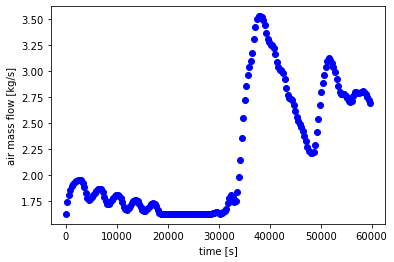

In [4]:
# This part is for testing the code. The control variable curve shown is based on sample curves of the state variables and there is no closed control loop.
Range = 200
t = np.arange(0, Range*200*t_step_controller, t_step_controller)
fig, ax = plt.subplots()
for i in range(Range):
    if i == 0:
        x0 = np.array([T_room_0, X_room_0, beta_CO2_room_0]).reshape(-1, 1)
        mpc.x0 = x0
        mpc.set_initial_guess()
        u0 = mpc.make_step(x0)
        ax.scatter(t[i], u0, color='blue')
        ax.set_xlabel('time [s]')
        ax.set_ylabel('air mass flow [kg/s]')
    else:
        x0 = np.array([data.T_room[i], data.X_room[i], data.beta_CO2_room[i]]).reshape(-1, 1)
        u0 = mpc.make_step(x0)
        ax.scatter(t[i], u0, color='blue')
        ax.set_xlabel('time [s]')
        ax.set_ylabel('air mass flow [kg/s]')
        
plt.show()